In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
from scipy.signal import detrend
import pandas as pd
from datetime import datetime

In [2]:
#import dask to parallelise
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46185 instead
  warnings.warn(


In [3]:
mask = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/sst_restore_mask_tropical_Pacific_Ocean_15S-15N_5degdampimg.nc", decode_times=False)

In [4]:
basins = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/basin_mask_20111103.nc", decode_times = False)

In [5]:
basins = basins.BASIN_MASK

In [6]:
mask = mask.restore_mask

In [7]:
PO = basins.where(basins == 3)

In [8]:
PO = xr.where(PO == 3, 1, 0)

In [9]:
PO = PO.rename({"ST_OCEAN1_1":"DEPTH1_1", "YT_OCEAN":"GRID_Y_T", "XT_OCEAN":"GRID_X_T"})

In [10]:
PO = PO.assign_coords({"DEPTH1_1":[0.0]})

In [11]:
PO2 = xr.concat([PO,PO,PO,PO,PO,PO,PO,PO,PO,PO,PO,PO], mask.TIME)

In [12]:
mask = mask.compute()

In [13]:
PO2 = PO2.compute()

In [14]:
new = mask+PO2

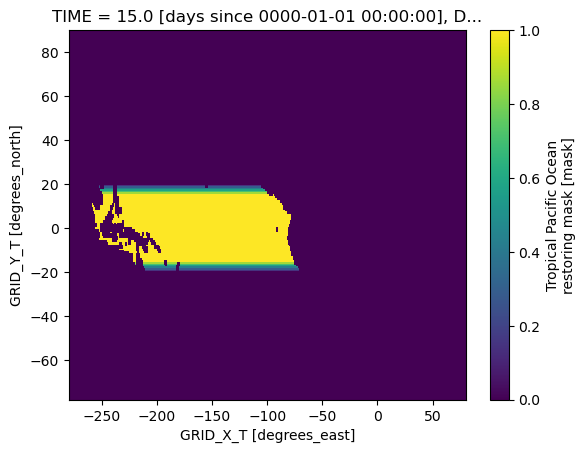

In [15]:
mask[0,0].plot()

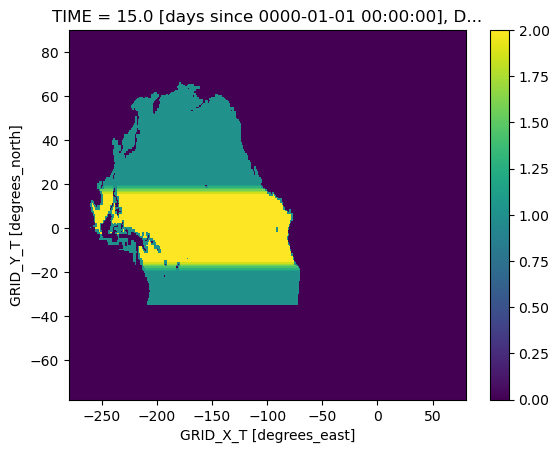

In [16]:
new[0,0].plot()

In [17]:
PO_30 = new.where(new.GRID_Y_T < 30, 0).where(new.GRID_Y_T > -30, 0)

In [18]:
PO_30_1 = xr.where(PO_30 >=1, 1, 0)

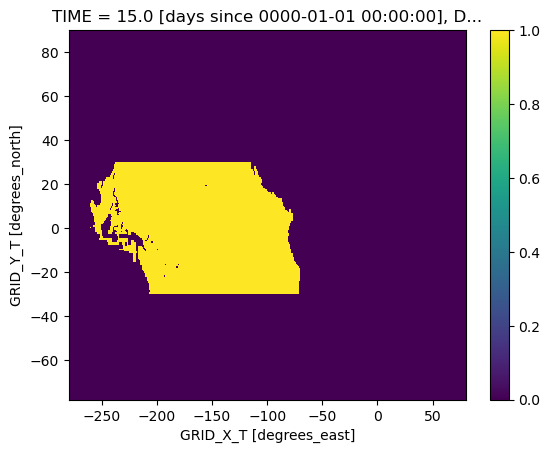

In [19]:
PO_30_1.where((PO_30_1.GRID_Y_T <30), 0)[0,0].plot()

In [20]:
latitude_values = PO_30_1.coords['GRID_Y_T']

# Create an array the same size as lat x lon with latitude values
# Repeat latitude values across lon dimension
latitude_array = xr.DataArray(latitude_values.data[:, None] * xr.ones_like(PO_30_1[0,0], dtype=bool),
                              dims=['GRID_Y_T', 'GRID_X_T'])

In [21]:
lower_limit = 25
upper_limit = 30

# Apply linear transformation to values between 25 and 30
masked_array = np.where(
    (latitude_array >= lower_limit) & (latitude_array <= upper_limit),
    1 - (latitude_array - lower_limit) / (upper_limit - lower_limit),
    latitude_array
)

# Create an xarray DataArray with the transformed values
transformed_latitude_array = xr.DataArray(masked_array, dims=['lat', 'lon'])


In [22]:
lower_limit = -30
upper_limit = -25
lowers = ((latitude_array - lower_limit) / (upper_limit - lower_limit))

lower_limit = 25
upper_limit = 30
uppers = (1-(latitude_array - lower_limit) / (upper_limit - lower_limit))

In [23]:
uppers = (uppers.where(uppers>0, 0).where(uppers<1,1)).where(lowers.GRID_Y_T>-25,0)

In [24]:
lowers = (lowers.where(lowers>0, 0).where(lowers<1,1)).where(lowers.GRID_Y_T<25,0)

In [25]:
latitude_mask = (lowers+uppers).where((lowers+uppers)<2, 1)

In [26]:
#add the time and depth dimesnion to latidue mask

In [27]:
latitude_mask = latitude_mask.expand_dims(dim = {"TIME":PO_30_1.TIME}, axis = 0).expand_dims(dim = {"DEPTH1_1":[0.0]}, axis = 1)

In [28]:
new_mask = latitude_mask.where(PO_30_1>0, 0)

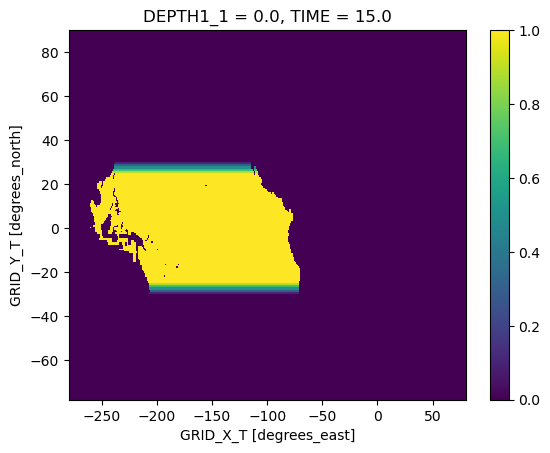

In [29]:
new_mask[0,0].plot()

In [30]:
new_mask = new_mask.assign_coords({"TIME":mask.TIME, "DEPTH1_1":mask.DEPTH1_1, "GRID_X_T":mask.GRID_X_T, "GRID_Y_T":mask.GRID_Y_T})

In [31]:
new_mask = new_mask.assign_attrs({"long_name": "Tropical Pacific Ocean restoring mask", "units": "mask", "valid_range": np.array([0.0, 1.0], dtype=np.float32)})
new_mask = new_mask.astype("float32")
new_mask = new_mask.to_dataset(name = 'restore_mask')
new_mask = new_mask.assign_attrs({"description": "Tropical Pacific Ocean restore mask 25S-25N plus 5deg damping to 30S-30N (1=restore, 0=no restore) for ACCESS-CM2 pacemaker experiments, Sebastian McKenna",
                                 "history": "Created 19/12/23"})

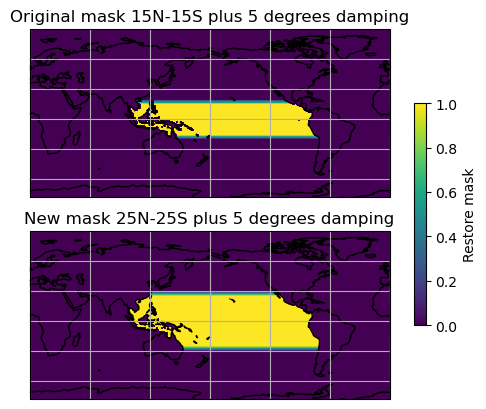

In [33]:
# Create a figure and axes for subplots
fig, axs = plt.subplots(nrows=2, ncols=1, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Plot the first mask on the first subplot (row 1)
mask[0, 0].plot(ax=axs[0], transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar = False)
axs[0].set_title('Original mask 15N-15S plus 5 degrees damping')
axs[0].coastlines(color='k')
axs[0].gridlines()
axs[0].set_facecolor('grey')

# Plot the second mask on the second subplot (row 2)
new_mask.restore_mask[0, 0].plot(ax=axs[1], transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar = False)
axs[1].set_title('New mask 25N-25S plus 5 degrees damping')
axs[1].coastlines(color='k')
axs[1].gridlines()
axs[1].set_facecolor('grey')

# Create a common colorbar
cbar = plt.colorbar(axs[1].collections[0], ax=axs, orientation='vertical', shrink=0.6, aspect=20)
cbar.set_label('Restore mask')  # Set colorbar label


In [ ]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

mask[0,0].plot(ax=ax, transform=ccrs.PlateCarree(),
                        )
ax.set_title('Original mask 15N-15S plus 5 degrees damping')
ax.coastlines(color = 'k')
ax.gridlines()
ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

In [ ]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

new_mask.restore_mask[0,0].plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_title('New mask 25N-25S plus 5 degrees damping')
ax.coastlines(color = 'k')
ax.gridlines()
ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False